<a href="https://colab.research.google.com/github/abhishekkallarappayi/Dissertation/blob/main/Pneumonia_Final_SE-ResNeXt50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_applications
!pip install keras_preprocessing
!pip install image-classifiers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import zipfile
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
import tensorflow as tf
from keras import  layers, models
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import keras
import tensorflow as tf
from classification_models.tfkeras import Classifiers

In [3]:
mkdir /root/.kaggle/

In [4]:

mv /kaggle.json /root/.kaggle

In [5]:
ls -a /root/.kaggle

./  ../  kaggle.json


In [6]:
! kaggle datasets download 'paultimothymooney/chest-xray-pneumonia'

100% 2.29G/2.29G [01:46<00:00, 24.2MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.1MB/s]


In [7]:

zipref=zipfile.ZipFile('/content/chest-xray-pneumonia.zip')

In [8]:
zipref.extractall(path="/content/")

Combining test and train sets

In [9]:
!mv /content/chest_xray/chest_xray/test/NORMAL/* /content/chest_xray/chest_xray/train/NORMAL/
!mv /content/chest_xray/chest_xray/test/PNEUMONIA/* /content/chest_xray/chest_xray/train/PNEUMONIA/

There are 1 files in /content/chest_xray/chest_xray/train/
There are 4266 files in /content/chest_xray/chest_xray/train/PNEUMONIA
There are 1576 files in /content/chest_xray/chest_xray/train/NORMAL
['PNEUMONIA', 'NORMAL']


<ipython-input-10-1ba5957d78dc>:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(names,count[1:],color="yb")


<BarContainer object of 2 artists>

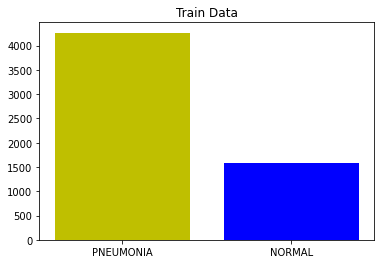

In [10]:
count=[]
names=[]
for root,dirname,file_name in os.walk('/content/chest_xray/chest_xray/train/'):
  print(f'There are {len(file_name)} files in {root}')
  names.extend(dirname)
  count.append(len(file_name))
names=[x for x in names if x]
print(names)
plt.title("Train Data")
plt.bar(names,count[1:],color="yb")

In [11]:
normal_path = '/content/chest_xray/chest_xray/train/NORMAL'
pneumonia_path = '/content/chest_xray/chest_xray/train/PNEUMONIA'
normal_images=Path(normal_path).glob('*.jpeg')
pneumonia_images=Path(pneumonia_path).glob('*.jpeg')
train_data=[]
for img in normal_images:
    train_data.append((img,0))
for img in pneumonia_images:
    train_data.append((img, 1))
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)
train_data

,image,label
0,/content/chest_xray/chest_xray/train/NORMAL/NO...,0
1,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
2,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
3,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
4,/content/chest_xray/chest_xray/train/NORMAL/NO...,0
...,...,...
5835,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
5836,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
5837,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
5838,/content/chest_xray/chest_xray/train/NORMAL/IM...,0


In [12]:
normal_images=Path(normal_path).glob('*.jpeg')
tuberculosis_images=Path(pneumonia_path).glob('*.jpeg')
normal_path = '/content/chest_xray/chest_xray/train/NORMAL'
pneumonia_path = '/content/chest_xray/chest_xray/train/PNEUMONIA'
# Get the list of all the images
normal_cases = Path(normal_path).glob('*.jpeg')
pneumonia_cases =Path(pneumonia_path).glob('*.jpeg')
train_data = []
train_labels = []
for img in tqdm(normal_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'normal'
    train_data.append(img)
    train_labels.append(label)
                      
# Pneumonia cases        
for img in tqdm(pneumonia_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Pneumonia'
    train_data.append(img)
    train_labels.append(label)
    
# Convert the list into numpy arrays

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

1575it [00:37, 41.58it/s]
4265it [00:33, 125.61it/s]


Total number of validation examples:  (5840, 28, 28, 3)
Total number of labels: (5840,)


In [13]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1['label']=train_labels1['label'].map({'normal':0,'Pneumonia':1})

In [14]:
#train_labels1.shape
train_data1.shape


(5840, 28, 28, 3)

Implementing SMOTE

In [15]:

smote = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smote.fit_resample(train_data1, train_labels1)

0    4265
1    4265
Name: label, dtype: int64


<ipython-input-16-b664179f4653>:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(labels.index,labels.values,color="yb")


([<matplotlib.axis.XTick at 0x7fa5ba764bb0>,
 [Text(0, 0, 'Normal'), Text(0, 0, 'Pneumonia')])

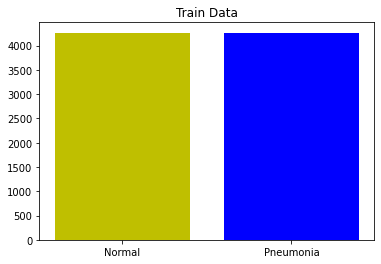

In [16]:
labels=train_labels2['label'].value_counts()
print(labels)
plt.title("Train Data")
plt.bar(labels.index,labels.values,color="yb")
plt.xticks(range(len(labels.index)), ['Normal', 'Pneumonia'])

In [17]:
train_data2 =train_data2.reshape(-1,28,28,3)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.13, random_state=42)

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(28,
                                  28,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
      
  ]
)

In [20]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu')
    
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)         

In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(640, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)         

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=7,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir='/content/logs/92p6accuracy_model/')
model.fit(np.array(X_train), np.array(y_train), epochs=20, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[early_stop_callback,tensorboard_callback])

Epoch 1/20
232/232 [==============================] - 15s 49ms/step - loss: 0.6973 - accuracy: 0.5053 - val_loss: 0.7184 - val_accuracy: 0.4779
Epoch 2/20
232/232 [==============================] - 5s 21ms/step - loss: 0.6978 - accuracy: 0.5005 - val_loss: 0.6924 - val_accuracy: 0.5221
Epoch 3/20
232/232 [==============================] - 5s 21ms/step - loss: 0.6961 - accuracy: 0.4924 - val_loss: 0.6933 - val_accuracy: 0.5221
Epoch 4/20
232/232 [==============================] - 5s 21ms/step - loss: 0.6959 - accuracy: 0.4941 - val_loss: 0.7131 - val_accuracy: 0.4779
Epoch 5/20
232/232 [==============================] - 6s 26ms/step - loss: 0.6950 - accuracy: 0.5103 - val_loss: 0.6923 - val_accuracy: 0.5221
Epoch 6/20
232/232 [==============================] - 5s 21ms/step - loss: 0.6954 - accuracy: 0.5080 - val_loss: 0.6956 - val_accuracy: 0.4779
Epoch 7/20
232/232 [==============================] - 5s 21ms/step - loss: 0.6967 - accuracy: 0.4912 - val_loss: 0.6922 - val_accuracy: 0.522

In [24]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

35/35 [==============================] - 0s 2ms/step


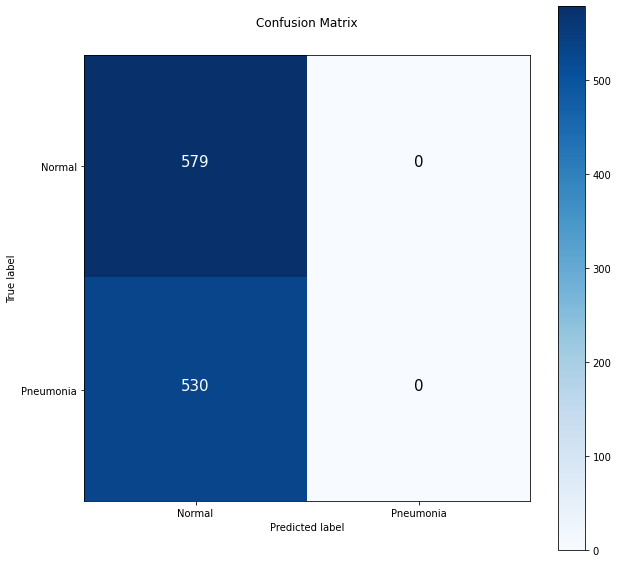

In [25]:
#After
y_pred=model.predict(X_test)
true_classes = y_test
true_classes
y_pred
preds_classes = np.argmax(y_pred, axis=-1)
#print(preds_classes)
make_confusion_matrix(true_classes, preds_classes, classes=["Normal","Pneumonia"])

In [26]:

SeResNeXT, preprocess_input = Classifiers.get('seresnext50')
base_model = SeResNeXT(include_top = False, input_shape=(28, 28, 3), weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model2 =tf.keras.Model(inputs=base_model.input, outputs=predictions)
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=7,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir='/content/logs/resnext50_model/')
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
r = model2.fit(
    x=X_train,y=y_train, 
    epochs=20,callbacks=[early_stop_callback,tensorboard_callback],validation_data=(np.array(X_test), np.array(y_test))
)

104679448/104679448 [==============================] - 14s 0us/step
Epoch 1/20
232/232 [==============================] - 75s 190ms/step - loss: 0.2352 - accuracy: 0.9104 - val_loss: 0.3295 - val_accuracy: 0.9179
Epoch 2/20
232/232 [==============================] - 37s 159ms/step - loss: 0.0946 - accuracy: 0.9678 - val_loss: 0.2072 - val_accuracy: 0.9648
Epoch 3/20
232/232 [==============================] - 36s 156ms/step - loss: 0.0675 - accuracy: 0.9760 - val_loss: 0.1554 - val_accuracy: 0.9612
Epoch 4/20
232/232 [==============================] - 36s 157ms/step - loss: 0.0718 - accuracy: 0.9733 - val_loss: 0.0871 - val_accuracy: 0.9757
Epoch 5/20
232/232 [==============================] - 34s 146ms/step - loss: 0.0503 - accuracy: 0.9826 - val_loss: 0.2026 - val_accuracy: 0.9414
Epoch 6/20
232/232 [==============================] - 34s 146ms/step - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.0858 - val_accuracy: 0.9711
Epoch 7/20
232/232 [==============================] - 35s 151m

In [27]:
model2.evaluate(X_test,y_test)

35/35 [==============================] - 1s 42ms/step - loss: 0.0871 - accuracy: 0.9757


[0.08713033050298691, 0.9756537675857544]

35/35 [==============================] - 6s 41ms/step


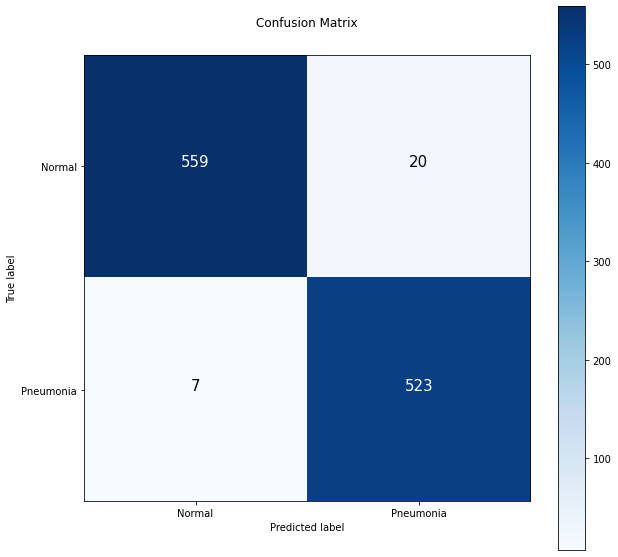

In [28]:
#After
y_pred2=model2.predict(X_test)
true_classes = y_test
true_classes
make_confusion_matrix(true_classes, y_pred2>0.5, classes=["Normal","Pneumonia"])

In [29]:
model2.save("/content/pneumonia_model/")

In [30]:
!zip -r "/content/pneumonia_model.zip" "/content/pneumonia_model"

  adding: content/pneumonia_model/ (stored 0%)
  adding: content/pneumonia_model/assets/ (stored 0%)
  adding: content/pneumonia_model/saved_model.pb (deflated 93%)
  adding: content/pneumonia_model/keras_metadata.pb (deflated 95%)
  adding: content/pneumonia_model/variables/ (stored 0%)
  adding: content/pneumonia_model/variables/variables.index (deflated 84%)
  adding: content/pneumonia_model/variables/variables.data-00000-of-00001 (deflated 12%)


Sample model with one picture

1/1 [==============================] - 1s 754ms/step


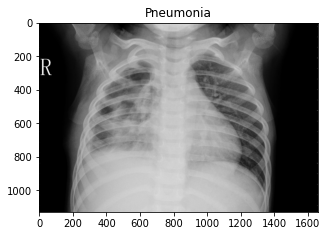

In [32]:
#Nomral
image_path='/content/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'
img = cv2.imread(str(image_path))
img_backup=cv2.imread(str(image_path))
img = cv2.resize(img, (28,28))
if img.shape[2] ==1:
    img = np.dstack([img, img, img])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=np.array(img)
img = img/255
img=np.array(img)
img =img.reshape(-1,28,28,3)
pred_res=model2.predict(img)
if pred_res>0.5:
  plt.figure(figsize = (5,5))
  plt.imshow(img_backup, cmap='gray')
  plt.title("Pneumonia")
else:
  plt.figure(figsize = (5,5))
  plt.imshow(img_backup, cmap='gray')
  plt.title("Normal")